# Which method should I use? -  A guide on benchmarking

## Introduction

Last week LinkedIn has shown me the following post 

<figure>
  <img src="post.jpeg" alt="Post" height="500">
</figure>

The LinkedIn post left out the original source which, after some reverse image search, I found to be the [allinpython](https://www.instagram.com/allinpython/) page.

This post presents five ways to reverse a list in Python. The natural question then becomes "Which way is more efficient?".  

This is a common question when making choices for programing. Given different methods for the same task, we should use the most efficient one. Most often that means the one with the smallest computational time.

But how can one determine which method is more efficient? This straightforward question does not always have a straightforward answer. This led me to write the present tutorial. 

As an illustrative example, we will explore the five methods in the post for reversing a list in Python. Then, we'll examine how the time required to reverse a list changes as the size of the list increases. In essence, we will investigate how the computational time scales with the number of elements in the list.

## The five methods to reverse a list in Python

The post that inspired this tutorial explains the five different methods by creating a small script which prints the correct result (the reversed list). However, if we want to understand when to use each method, it is more useful to have the task executed for a generic list, which we can then modify to mimic real scenarios where we want to reverse lists (*e.g.* longer/shorter lists). The following block of code creates a specific function that reverses lists using each of the five methods:

In [1]:
def method1(my_list):
    return my_list.reverse()

def method2(my_list):
    return my_list[::-1]

def method3(my_list):
    return list(reversed(my_list))

def method4(my_list):
    reversed_list =[]
    for i in my_list:
        reversed_list.insert(0,i)
    return reversed_list

def method5(my_list):
    reversed_list =[]
    for i in range(len(my_list)-1,-1,-1):
        reversed_list.append(my_list[i])
    return reversed_list

A reader who is more familiar with high level languages, such as Python, might be able to foreshadow the answer. 

First, Methods #4 and #5 require the creation of new lists, necessitating the allocation of new memory, and they also require `for` loops, which are known to be inefficient in high-level languages and are encouraged to be replaced by vectorized code (for more details, see the series by my colleague [Lance Xu](https://labpresse.com/author/weiqing/) on [optimization techniques in computing](https://labpresse.com/optimization-techniques-in-scientific-computing-part-i/)).

Second, among Methods #1 - #3, only Method #1 uses [built-in functions](https://docs.python.org/3/library/functions.html) exclusively and is therefore likely to be better optimized.

Therefore, one can expect that Methods #4 and #5 are significantly slower than Methods #1-3, with Method #1 being the faster option overall.

## Measuring time

There are [several tools for measuring the execution time of a code in python](https://pynative.com/python-get-execution-time-of-program/). In this post, we choose the `timeit` library, which offers a simple method for timing specific segments of Python code. 

Interestingly, we have used `timeit` in a [previous post](https://labpresse.com/sparse-matrices-in-numba/) where I presented the [`smn`](https://github.com/PessoaP/smn) library for sparse matrices. There I have used `timeit` to show how more efficient `smn` was when compared to more naive methods.

In [2]:
import timeit

Let us give an example on how to measure the execution time using `timeit`. For this let us create a moderatly large list (1000 elements) and measure the time needed to apply Method #1 to it.

In [3]:
my_list = list(range(1000))
l = lambda: method1(my_list)
timeit.timeit(l,number=10)

5.263980710878968e-06

A few comments are relevant here. Firstly, the variable `l` is a [lambda function](https://docs.python.org/3/reference/expressions.html), which we shall not describe here in depth. Here we use the `lambda` expression solely to write the piece of code we want to measure in terms of execution time, in this case, `method1` applied to the list. Secondly, the function `time.timeit` takes as arguments not only the lambda expression but also the number of repetitions. In other words, `timeit.timeit(l, number=10)` measures only the time *in seconds* needed to repeat the code in `l` 10 times.



## Measuring scaling

When we talk about *scaling* in the context of algorithms, we are referring to how well an algorithm performs with increased workload or input size. For this we not only ought to do the the mesurement described above, but also perform it at lists of different sizes, in the span of different [orders of magnitude](https://en.wikipedia.org/wiki/Order_of_magnitude).

For that purpose, let us create a list of all the methods

In [4]:
methods = [method1,method2,method3,method4,method5]

and another one of the list sizes we want to benchmark these methods on

In [5]:
Ns_list = [100,1000,10000,100000,1000000]

Now, let us conduct a time benchmark using the following block of code to measure the execution time of each function in the `methods` list when inverting a list of varying sizes in the `Ns_list`.

In [6]:
times = []
for N in Ns_list:
    times_N = []    
    for met in methods:
        my_list = list(range(N))
        l = lambda: met(my_list)

        ex_time = timeit.timeit(l,number=10)

        times_N.append(ex_time)
    times.append(times_N)



The list `times` contains the necessary information. But before moving towards visualizing it, we should point out that as the lengths of our lists span different orders of magnitude, it becomes necessary to graph the results in [log-log scale](https://en.wikipedia.org/wiki/Log%E2%80%93log_plot).  This approach helps us better understand the relationship between input size and execution time, usually algorithms exhibit behaviors like "[order of N to the power of something](https://en.wikipedia.org/wiki/Time_complexity)", expressed as $O(N^\alpha)$. Log-log plots not only allow one to observe the different order of magnitudes but also the relationship time-size becomes linear with the exponent, $\alpha$, being the slope. 



With this in mind, let us observe the results.

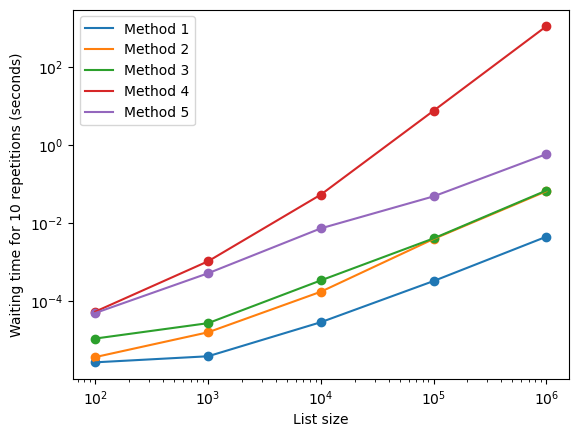

In [7]:
from matplotlib import pyplot as plt
import numpy as np

for i in range(len(times)):
    plt.scatter(Ns_list,np.array(times)[:,i])
    plt.plot(Ns_list,np.array(times)[:,i],label='Method {}'.format(i+1))
plt.legend()

plt.ylabel('Waiting time for 10 repetitions (seconds)')
plt.yscale('log')
plt.xlabel('List size')
plt.xscale('log')

Now, we can observe that the results align with what was anticipated. Indeed, Methods #1-3 perform significantly better than Methods #4 and #5, with #1 emerging as the overall winner.

However, it is essential to note that the comparison changes significant changes as the list size grows. For lists containing hundreds of elements, Methods #1 and #2 exhibit similar performance. As the size increases, Method #1 becomes considerably superior, and when dealing with lists in the order of millions, Methods #2 and #3 become comparable.

Furthermore, despite our anticipation that #4 and #5 would perform considerably worse, the graph shows us just how much (Method #4 takes approximately $1000$ times longer than its closest competitor). Even in this simple example, benchmarking is a vital part of writing fast code. The image at the beginning of this post might have convinced a less experienced programmer that all methods have similar performance. If they had decided to (seemingly arbitrarily)  implement Method #4, they would inadvertently produce an unnecessarily inefficient piece of software.

## Conclusion

In summary, this post hopefully described one way benchmark code for various input sizes and highlighted the essential role benchmarking in writing code. I feel compelled to emphasize however that time benchmarking is not the ultimate *all-encompassing* metric for determining which method to use. For instance, in scientific computing, where mathematical approximations are often employed, we frequently seek a balanced compromise between processing time and approximation accuracy, adding another variable to the necessary benchmarks."

On an interesting note, a problem highly similar to what was presented here was the object of study of a recently released article from us. In [Avoiding matrix exponentials for large transition rate matrices](https://arxiv.org/abs/2312.05647) we conducted benchmarking on four distinct alternatives to the matrix exponential (as opposed to examining five methods for list inversion) within an inference problem that typically demands a substantial number of matrix exponential calculations. I would like to encourage readers to explore this article for a closer look at how benchmarking applies in the natural sciences